In [1]:
import numpy as np
import matplotlib.pyplot as plt     # optional
import scipy.stats as stats         # probably don't need
import scipy.special as special     # maybe, for logsumexp()
import seaborn as sns               # optional
import pandas as pd                 # optional

%matplotlib inline

**Question 1:** Implement a expectation-maximization motif finding algorithm.

**Given:** We have a set of N fragment sequences of length L, each of which contains a motif of length W.

First, I define my function <code>random_pwm</code> to generate a random motif matrix. This probability weight matrix (PWM) takes in a width (w) as input.

In [2]:
def random_pwm(w: int):
    # initialize a random motif matrix
    # initialization step of a w (width) x 4 PWM 
    pwm = np.random.dirichlet([1, 1, 1, 1], size=w)
    
    return pwm

Then, I calculate the background probabilities, or a vector with the frequencies of each of the four nucleotides across a list of sequences.

In [3]:
# background probabilities
# frequencies of each nucleotide for all sequences in a file
def background_probs(sequences):
    """
    Calculate the background nucleotide probabilities for a given list of sequences.
    
    Parameters:
    - sequences: list of sequences to calculate background probabilities for
    """

    # concatenate all sequences into one long string for ease of computation
    all_bases = ''.join(sequences) 
    base_counts = np.bincount([{'a': 0, 'c': 1, 'g': 2, 't': 3}[base] for base in all_bases], minlength=4)
    total_length = len(all_bases)
    
    # normalize counts by the total length to get frequencies
    f = base_counts / total_length
    
    return f

**Function 1:** A routine to calculate a posterior distribution for the inferred motif position on an input sequence.

In [4]:
def calculate_posterior(w: int, sequence: str, pwm):
    """
    Calculate the posterior probability for each position in the sequence and 
    return the posterior probability distribution as an array, posteriors. This will be called
    on every sequence in a list of sequences.
    
    Parameters:
    - w: width of the motif
    - sequence: a singular DNA sequence
    - pwm: an i.i.d. position weight matrix of dimensions (w x 4)
    """
    
    posteriors = []
    L = len(sequence)

    for i in range(L-w+1):
        # for each sequence, calculate the posterior probabilities for each "window", or subsequence
        subsequence = sequence[i:i+w]
        # initialize likelihood to 1
        likelihood = 1

        # iterate through every nucleotide within the subsequence
        for j, nt in enumerate(subsequence):
            # index or find...?
            nt_idx = 'acgt'.find(nt)

            # update the PWM at each nucleotide position and for every sequence in the file
            likelihood *= pwm[j][nt_idx]
        posteriors.append(likelihood)

    # normalization step: divide the array by the sum of all of the posterior probabilities
    posteriors = np.array(posteriors) / np.sum(posteriors)  
    return posteriors

In [5]:
# function to calculate counts matrix, or cka
def counts_matrix(w: int, sequences, pwm):
    # initialize a counts matrix to 0, across all of the sequences
    counts = np.zeros((w, 4))
    
    for sequence in sequences:
        L = len(sequence)
        # calculate the posterior probabilities for every sequence given the i.i.d. generated PWM
        posteriors = calculate_posterior(w, sequence, pwm)
        
        # collect expected counts for each nucleotide at each motif position
        # weigh every possible starting position (lambda) using the calculated posterior probability distribution
        for i in range(L-w+1):
            subseq = sequence[i:i+w]
            for j, nt in enumerate(subseq):
                nt_idx = 'acgt'.find(nt)
                counts[j][nt_idx] += posteriors[i]
    return counts

Next, we write a function for the maximization step that computes the formula below for our ccounts matrix: 

$$ 
\hat{p}_i = \frac{c_i}{\sum_j c_j}, j = (a, t, c, g)
$$

In [14]:
# Maximization-step: normalization
def update_pwm(counts):
    # normalize counts to form probabilities and create a new PWM
    pwm = counts / counts.sum(axis=1, keepdims=True)
    return pwm

<code>convergence_check</code> checks every iteration for convergence and to see if the pka matrix needs to be further maximized.

In [15]:
def convergence_check(iteration, new_pwm, pwm, threshold: float):
# check convergence
    if np.all(np.abs(new_pwm - pwm) < threshold):
        print(f"Converged after {iteration + 1} iterations.")
        return True
    else:
        return False

We will also define a function to calculate the relative entropy ofthe identified PWM $p_k (a)$. The formula for relative entropy that our <code>calculate_relative_entropy</code> follows is:
$$ \sum^W_{k=1} \sum_a p_k (a) log_2 \frac{p_k (a)}{f(a)} $$

In [24]:
def calculate_relative_entropy(w, pwm, bg_frequencies):
    """
    Calculate the relative entropy between the PWM and background frequencies.
    
    Parameters:
    - pwm: array of shape (w, 4), where w is the motif width and 4 is for a, c, g, t
    - bg_frequencies: vector of length 4 with background probabilities for a, c, g, t; generated by background_probs function
    
    Returns:
    - relative_entropy: float, the total relative entropy score
    """
    
    relative_entropy = 0.0
    
    # iterate over motif positions
    for k in range(w):  
        # iterate over nucleotides A, C, G, T
        for a in range(4):     
            # avoid the case of log(0)
            if pwm[k][a] > 0:  
                relative_entropy += pwm[k][a] * np.log2(pwm[k][a]/bg_frequencies[a])
    return relative_entropy

Below is my overarching **E-M algorithm**, which takes in a list of sequences from a converted FASTA file, a width (w) of the motif, the number of iterations, and a threshold. It utilizes the previously defined functions to enact the entire algorithm from start to finish.

In [25]:
def em_algorithm(sequences, w, max_iter=100, threshold=1e-4):
    
    # initialize PWM - the original probabilities will be relatively random
    # the PWM is initialized once per iteration (once per E-M)
    pwm = random_pwm(w)

    # calculate our background probabilities
    f = background_probs(sequences)
    
    for iteration in range(max_iter):
        # E-step
        counts = counts_matrix(w, sequences, pwm)
        
        # M-step
        new_pwm = update_pwm(counts)

        # if the iteration converges; if convergence_check returns "True"
        if convergence_check(iteration, new_pwm, pwm, threshold):
            break
            
        # pka is then updated for every sequence
        pwm = new_pwm
        
        # calculate and report the relative entropy using the width, updated pwm, and calculated background frequencies
        relative_entropy = calculate_relative_entropy(w, pwm, f)

    return pwm, relative_entropy

**Question 2:** Do a synthetic positive control.

Create a known motif PWM of some length W (4-8nt, say). To make a synthetic positive sequence, embed one sampled motif from the PWM at a random position in a larger random (i.i.d.) sequence of length L of a given background residue composition. Generate a synthetic positive control dataset of N sequences of length L, for N and L comparable to the size of Lestrade's datasets.

Analyze your synthetic positive control dataset with your EM algorithm, choosing W appropriately. Do you identify the motif that you embedded in the sequences?

Below, my function <code>syn_random</code> generates a random synthetic dataset of N sequences of length L, for N and L comparable to the size of Lestrade's datasets. We will use this in both question 2 and question 3.

In [79]:
# list of four nucleotide bases
nucleotides = ['a', 'c', 'g', 't']

import random

# function to generate a synthetic positive control dataset
def syn_random(n: int, L):
    """
    Function to generate a synthetic dataset. 

    Parameters:
    - n: number of sequences
    - L: length of each sequence
    """
    syn_sequences = []

    for i in range(n):        
        sequence = ''.join(random.choices(nucleotides, k = L))
        syn_sequences.append(sequence)

    return syn_sequences

In [80]:
# initialize a pwm for the positive controls 
pos_width = 7
pos_pwm = random_pwm(pos_width)
pos_pwm

array([[0.34204147, 0.44102388, 0.19709608, 0.01983857],
       [0.05580904, 0.00743651, 0.59546204, 0.34129241],
       [0.03676307, 0.18628444, 0.03784404, 0.73910845],
       [0.24706625, 0.23545985, 0.19924167, 0.31823222],
       [0.15266324, 0.00915638, 0.66070344, 0.17747695],
       [0.0398233 , 0.02684316, 0.20710992, 0.72622361],
       [0.32653937, 0.02852146, 0.48608876, 0.15885041]])

The motif extracted from the simple, randomly generated PWM above is cgttgtg. 

In [81]:
# hint: generate N=200 sequences of length L=50
# insert the sequence 'cgttgtg' into a random overall list of sequences
N = 200
L = 50

positive_controls = syn_random(N, L)

pos_bg = background_probs(positive_controls)

In [82]:
# generate a random background sequence of the specified length
motif = 'cgttgtg'

# Choose a random position to embed the motif
start_pos = np.random.randint(0, L-len(motif)+1)

idx = np.random.randint(200)

positive_controls[idx] = positive_controls[idx][:start_pos] + motif+positive_controls[idx][start_pos + len(motif):]

In [83]:
pos_width = 7
positive_dist = em_algorithm(positive_controls, pos_width)
print("PWM for Positive Controls:", positive_dist[0])
print("Relative Entropy for Positive Controls:", positive_dist[1])

PWM for Positive Controls: [[1.31071736e-01 2.35958857e-01 3.66701751e-03 6.29302390e-01]
 [2.12335573e-01 3.08393526e-01 4.37326556e-01 4.19443446e-02]
 [3.08042549e-01 3.69542893e-02 4.55801965e-01 1.99201197e-01]
 [1.87232717e-01 5.01807461e-01 2.22680720e-01 8.82791018e-02]
 [3.76884428e-01 2.55738103e-01 3.66490975e-01 8.86494595e-04]
 [3.17673949e-01 1.32388282e-01 1.35312484e-01 4.14625286e-01]
 [3.68486274e-05 3.57969510e-01 3.10557900e-01 3.31435742e-01]]
Relative Entropy for Positive Controls: 2.549318953265543


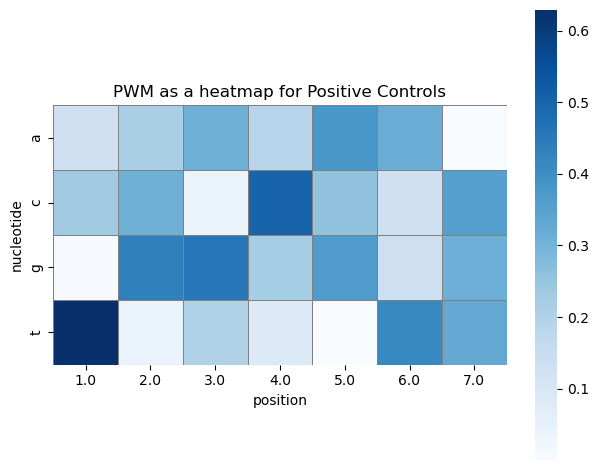

In [84]:
ylabels = ['a', 'c', 'g', 't']
xlabels = np.linspace(1, pos_width, pos_width)

# the Seaborn "heatmap" plot
fig, ax = plt.subplots()
sns.heatmap(positive_dist[0].T,  # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=True,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set(xlabel='position',                
       ylabel='nucleotide',
       title='PWM as a heatmap for Positive Controls')             
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

# Finally, we save the whole Figure to a file.
fig.set_tight_layout(True)

plt.show()

**Interpretation:** Based on the heat map above, we get TGGCATC as our motif. Our embedded motif was CGTTGTG, so we did not identify our embedded motif, as the only overlap is 'TG'.

**Question 3:** Do a synthetic negative control.

Generate a synthetic negative control dataset with similar characteristics as the dataset above, but without embedding any motif (i.e. all N sequences are just iid random sequences of length L, of some given background composition).

In [43]:
# synthetic negative control
# hint: generate N=200 sequences of length L=50
N = 200
L = 50

negative_controls = syn_random(N, L)

In [47]:
neg_width = 7
negative_dist = em_algorithm(negative_controls, neg_width)
print("PWM for Negative Controls:", negative_dist[0])
print("Relative Entropy for Negative Controls:", negative_dist[1])

PWM for Negative Controls: [[0.45767751 0.00307683 0.44501488 0.09423078]
 [0.15206843 0.3767216  0.02853685 0.44267312]
 [0.00261495 0.22018985 0.26639734 0.51079785]
 [0.00778389 0.57515607 0.22046634 0.19659369]
 [0.44237007 0.08272392 0.12280847 0.35209753]
 [0.13254894 0.20736134 0.27631921 0.3837705 ]
 [0.08830318 0.28305467 0.29581447 0.33282768]]
Relative Entropy for Negative Controls: 2.522528367066942


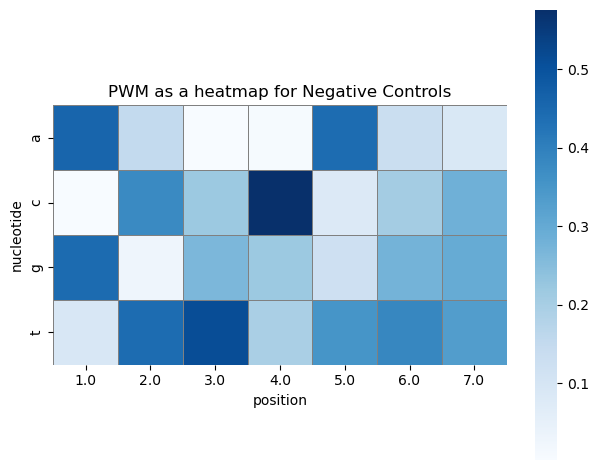

In [68]:
ylabels = ['a', 'c', 'g', 't']
xlabels = np.linspace(1, neg_width, neg_width)

# the Seaborn "heatmap" plot
fig, ax = plt.subplots()
sns.heatmap(negative_dist[0].T,  # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=True,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set(xlabel='position',                
       ylabel='nucleotide',
       title='PWM as a heatmap for Negative Controls')             
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

# Finally, we save the whole Figure to a file.
fig.set_tight_layout(True)

plt.show()

Analyze your synthetic positive control dataset with your EM algorithm, for an appropriate choice of W that you can compare to your results above. What is the score of the best identified motif in negative control data, compared to positive control data?

**Interpretation**: From our negative controls, we get ATTCATT as our motif. From our positive controls, we get TGGCATC as our motif. The score of the best identified motif in the negative control data is 2.5225, as compared to a score of 2.549 from the positive control data.

**Question 4:** Identify the ribosome binding sites in Lestrade's phage.

Analyze Lestrade's three datasets, for an appropriate choice of W. What is your best inference for the ribosome binding site consensus motif in each phage?

In [10]:
# function to convert FASTA file to a list of sequences
def converter(file_name):

    # read and open the file
    with open(file_name, 'r') as file:
        sequences = []
        sequence = ''  

        for line in file:
            # if the line starts with '>', it's a new sequence header
            if line.startswith('>'):
                # if there's already a sequence, append it to sequences list
                if sequence:
                    sequences.append(sequence)
                    sequence = ''  # reset for the next sequence

            # strip whitespace/linebreaks and add the line to the current sequence
            else:
                sequence += line.strip()

        # append the last sequence after the loop ends
        if sequence:
            sequences.append(sequence)
    
    # return the list of sequences
    return sequences

In [19]:
# convert FASTA files into a list of sequences ('aj', 'hh', 't4')
aj = converter('AluminumJesus-upstream.fa')
hh = converter('HangryHippo-upstream.fa')
t4 = converter('T4-upstream.fa')

In [63]:
# run the EM algorithm on each set of sequences
# set a variable for width so that we can vary it in our following analyses
width = 5
t4_dist = em_algorithm(t4, width)
aj_dist = em_algorithm(aj, width)
hh_dist = em_algorithm(hh, width)

print("PWM for T4:", t4_dist[0])
print("Relative Entropy for T4:", t4_dist[1])

print("PWM for AluminumJesus:", aj_dist[0])
print("Relative Entropy for AluminumJesus:", aj_dist[1])

print("PWM for HangryHippo:", hh_dist[0])
print("Relative Entropy for HangryHippo:", hh_dist[1])

Converged after 82 iterations.
PWM for T4: [[4.74210255e-01 2.63472413e-19 2.54152136e-01 2.71637609e-01]
 [3.16945928e-01 4.51594114e-02 1.36865461e-01 5.01029199e-01]
 [3.55489925e-01 4.92032387e-18 1.59172899e-01 4.85337176e-01]
 [7.50858527e-01 6.41963051e-09 1.54411928e-01 9.47295385e-02]
 [7.84124708e-01 1.89552067e-06 6.68028703e-04 2.15205368e-01]]
Relative Entropy for T4: 1.7433403351604402
PWM for AluminumJesus: [[5.70163583e-01 1.80167170e-01 1.47699203e-01 1.01970044e-01]
 [1.67406496e-02 4.96731036e-02 9.27881736e-01 5.70451087e-03]
 [7.85638844e-02 5.40243637e-02 8.67411752e-01 2.16700588e-43]
 [6.28073417e-01 6.27561399e-02 1.14983563e-01 1.94186881e-01]
 [5.49653331e-02 1.40823362e-01 7.78145919e-01 2.60653864e-02]]
Relative Entropy for AluminumJesus: 3.6701773686239223
PWM for HangryHippo: [[4.25193703e-01 3.27196770e-02 4.59091540e-01 8.29950798e-02]
 [6.89417760e-01 5.51712358e-06 2.08620940e-01 1.01955783e-01]
 [1.94459105e-01 4.85945277e-02 7.00627235e-01 5.6319131

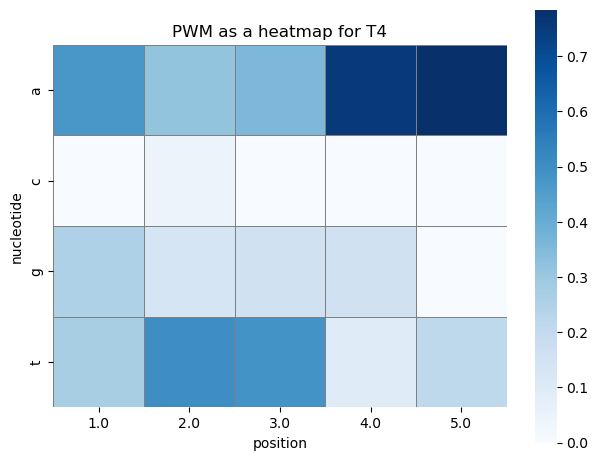

In [64]:
# letters on vertical y axis
# positions on the horizontal x axis

ylabels = ['a', 'c', 'g', 't']
xlabels = np.linspace(1, width, width)

# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
fig, ax = plt.subplots()
sns.heatmap(t4_dist[0].T,  # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=True,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set(xlabel='position',                
       ylabel='nucleotide',
       title='PWM as a heatmap for T4')             
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

# Finally, we save the whole Figure to a file.
fig.set_tight_layout(True)

plt.show()

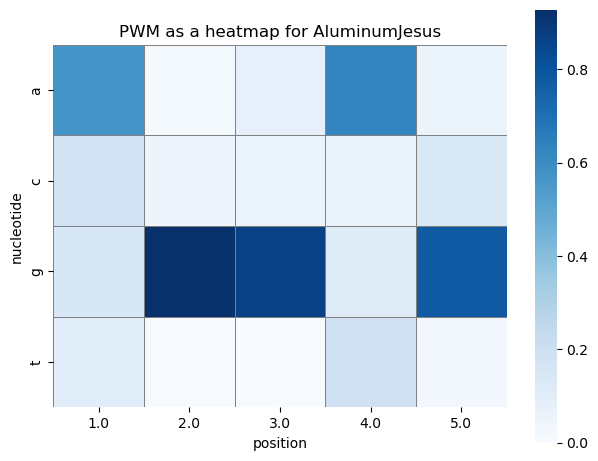

In [65]:
# letters on vertical y axis
# positions on the horizontal x axis

ylabels = ['a', 'c', 'g', 't']
xlabels = np.linspace(1, width, width)

# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
fig, ax = plt.subplots()
sns.heatmap(aj_dist[0].T,  # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=True,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set(xlabel='position',                
       ylabel='nucleotide',
       title='PWM as a heatmap for AluminumJesus')             
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

# Finally, we save the whole Figure to a file.
fig.set_tight_layout(True)

plt.show()

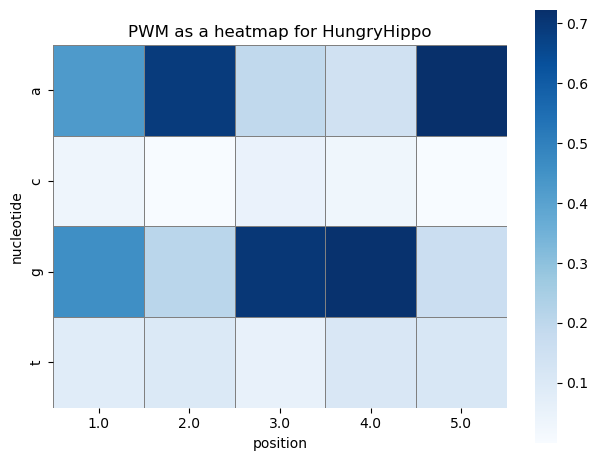

In [66]:
# letters on vertical y axis
# positions on the horizontal x axis

ylabels = ['a', 'c', 'g', 't']
xlabels = np.linspace(1, width, width)

# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
fig, ax = plt.subplots()
sns.heatmap(hh_dist[0].T,  # takes a 2D array of data
            ax=ax,
            xticklabels=xlabels,  #   ... set custom x axis labels
            yticklabels=ylabels,  #   ... set custom y axis labels
            cbar=True,           #   ... turn off the default color scale bar
            square=True,          #   ... force the plot to be square
            linecolor='grey',     #   ... set grid line color
            linewidth=0.5,        #   ... set grid line width
            cmap='Blues')         #   ... set the heat map color scheme ('color map', cmap) 

ax.set(xlabel='position',                
       ylabel='nucleotide',
       title='PWM as a heatmap for HungryHippo')             
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels

# Finally, we save the whole Figure to a file.
fig.set_tight_layout(True)

plt.show()

For each of the three genomes, the deduced motif from my EM algorithm for varying widths are as follows:
- T4: 4: ATAA, 5: ATTAA, 6: TGAGGA, 7: AGGAAAA, 8: AGGAAAAT
- AluminumJesus: 4: GGAG, 5: AGGAG, 6: AGGAGG, 7: GAGGAGG, 8: GGAGGAGA
- HungryHippo: 4: GGAG, 5: GAGGA, 6: GGAGGA, 7: AGGAGGA, 8: AAAGGAGA

Thus, it appears that the motifs for each genome are as follows (by my best inference):
- T4: AGGA
- AluminumJesus: GGAGG
- HungryHippo: GGAGGA

In [85]:
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyter,scipy,math

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyter   : 1.1.1
scipy     : 1.14.1
math      : unknown

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

